# validation fall semester hexo only

## all files general model, test error estimation

In [2]:
import pandas as pd
import os
import glob
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

source_directory = "/Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(source_directory, '*.csv'))

# Create a dictionary to store dataframes
dataframes = {}

# Load all CSV files into the dictionary
for file in csv_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    dataframes[file_name] = pd.read_csv(file)

# Print available files for the user to choose
print("Available files:")
for idx, file in enumerate(dataframes.keys()):
    print(f"{idx + 1}: {file}")

# Let the user choose multiple files for training and testing
selected_files_indices = [int(x) for x in input("Enter the indices of the files you want to use for training (comma separated): ").split(",")]

# Combine all selected files into single dataframes
selected_dfs = [dataframes[list(dataframes.keys())[idx - 1]] for idx in selected_files_indices]

# Combine all selected dataframes into single dataframes
combined_df = pd.concat(selected_dfs)

# Print column names for user to choose
print("\nColumns in Combined File:")
for idx, col in enumerate(combined_df.columns):
    print(f"{idx + 1}: {col}")

selected_columns = [int(x) - 1 for x in input("Enter the index of columns to use for training (comma separated): ").split(",")]

# Prepare data for training
X = combined_df.iloc[:, selected_columns]
y = combined_df['Stress Levels']

# Map classes 1 and 2 to a single class 1
y[y.isin([1, 2])] = 1

# Remove NaN values
X.dropna(inplace=True)
y = y.reset_index(drop=True)[X.index]  # Reset index after dropping NaNs

# Remove outliers using Z-score
z_scores = stats.zscore(X)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X = X[filtered_entries]
y = y[filtered_entries]

# Undersample the "0" stress levels to match the number of "1" stress levels
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled)

# Models to use for training
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Neural Network": MLPClassifier(),
    "K Nearest Neighbors": KNeighborsClassifier()
}

# Train the models
for name, model in models.items():
    print("\n", "-"*20, name, "Training", "-"*20)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"Cross-validation F1 scores for {name}: {cv_scores}")
    print(f"Mean F1 score for {name}: {cv_scores.mean()}")
    
    accuracy_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    print("Cross-validation Accuracy scores:")
    print(accuracy_scores)
    print(f"Mean Accuracy across all folds: {accuracy_scores.mean()}")

# Now, let's allow the user to pick the files to test on
while True:
    print("\nAvailable files for testing:")
    for idx, file in enumerate(dataframes.keys()):
        print(f"{idx + 1}: {file}")

    # Let the user choose multiple files for testing
    test_file_idx = int(input("\nEnter the index of the file you want to test on (enter '0' to quit): "))
    
    if test_file_idx == 0:
        print("Exiting...")
        break

    if test_file_idx - 1 not in range(len(dataframes.keys())):
        print("Invalid index. Please try again.")
        continue

    test_file_name = list(dataframes.keys())[test_file_idx - 1]
    test_df = dataframes[test_file_name]

    # Print column names for user to choose
    print("\nColumns in Selected Test File:")
    for idx, col in enumerate(test_df.columns):
        print(f"{idx + 1}: {col}")

    test_columns = [int(x) - 1 for x in input("Enter the index of columns for testing (comma separated): ").split(",")]

    # Prepare data for testing
    X_test_new = test_df.iloc[:, test_columns]
    y_test_new = test_df['Stress Levels']

    # Map classes 1 and 2 to a single class 1
    y_test_new[y_test_new.isin([1, 2])] = 1

    # Remove NaN values
    X_test_new.dropna(inplace=True)
    y_test_new = y_test_new.reset_index(drop=True)[X_test_new.index]  # Reset index after dropping NaNs

    # Remove outliers using Z-score
    z_scores_test_new = stats.zscore(X_test_new)
    abs_z_scores_test_new = abs(z_scores_test_new)
    filtered_entries_test_new = (abs_z_scores_test_new < 3).all(axis=1)
    X_test_new = X_test_new[filtered_entries_test_new]
    y_test_new = y_test_new[filtered_entries_test_new]

    # Scale the new test data
    X_test_new_scaled = scaler.transform(X_test_new)

    # Testing the trained models on the new data
    for name, model in models.items():
        print("\n", "-"*20, name, "Testing", "-"*20)
        y_pred_new = model.predict(X_test_new_scaled)

        test_f1_new = f1_score(y_test_new, y_pred_new)
        test_accuracy_new = accuracy_score(y_test_new, y_pred_new)
        print(f"Test F1 Score for {name} on New Data: {test_f1_new}")
        print(f"Test Accuracy for {name} on New Data: {test_accuracy_new}")


Available files:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_combined_hexo_p2-spring_modified
6: modified_combined_hexo_p3-spring_modified
7: modified_combined_hexo_p4_spring_modified
8: modified_combined_hexo_p4_fall_modified
Enter the indices of the files you want to use for training (comma separated): 1,2,3,4,5,6,7,8

Columns in Combined File:
1: Time [s/256]
2: Respiration Rate (rpm)
3: Breathing Volume (liters/min)
4: Adjusted Breathing Volume (liters/min)
5: Activity (g)
6: Heart Rate (bpm)
7: Stress Levels
Enter the index of columns to use for training (comma separated): 2,3,4,5,6


/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/215411156.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)



 -------------------- Random Forest Training --------------------
Cross-validation F1 scores for Random Forest: [0.65208321 0.65174186 0.65248743 0.65541641 0.65026719]
Mean F1 score for Random Forest: 0.6523992208967877
Cross-validation Accuracy scores:
[0.6483914  0.64894792 0.64828501 0.65110855 0.64721288]
Mean Accuracy across all folds: 0.6487891510553496

 -------------------- XGBoost Training --------------------
Cross-validation F1 scores for XGBoost: [0.60778132 0.60709159 0.61065958 0.60612754 0.60638701]
Mean F1 score for XGBoost: 0.6076094065780872
Cross-validation Accuracy scores:
[0.59275537 0.59226432 0.59226432 0.59134769 0.59146227]
Mean Accuracy across all folds: 0.5920187908697324

 -------------------- Neural Network Training --------------------
Cross-validation F1 scores for Neural Network: [0.59546168 0.60211625 0.61173914 0.56926237 0.55337785]
Mean F1 score for Neural Network: 0.5863914576559811
Cross-validation Accuracy scores:
[0.58250059 0.57594507 0.578711

ValueError: invalid literal for int() with base 10: '1,2,3,4,5,6,7,8'

# person specific models hexo only

# p2

In [ ]:
import pandas as pd
import os
import glob
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

source_directory = "/Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(source_directory, '*.csv'))

# Create a dictionary to store dataframes
dataframes = {}

# Load all CSV files into the dictionary
for file in csv_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    dataframes[file_name] = pd.read_csv(file)

# Print available files for the user to choose
print("Available files:")
for idx, file in enumerate(dataframes.keys()):
    print(f"{idx + 1}: {file}")

# Let the user choose multiple files for training and testing
selected_files_indices = [int(x) for x in input("Enter the indices of the files you want to use for training (comma separated): ").split(",")]

# Combine all selected files into single dataframes
selected_dfs = [dataframes[list(dataframes.keys())[idx - 1]] for idx in selected_files_indices]

# Combine all selected dataframes into single dataframes
combined_df = pd.concat(selected_dfs)

# Print column names for user to choose
print("\nColumns in Combined File:")
for idx, col in enumerate(combined_df.columns):
    print(f"{idx + 1}: {col}")

selected_columns = [int(x) - 1 for x in input("Enter the index of columns to use for training (comma separated): ").split(",")]

# Prepare data for training
X = combined_df.iloc[:, selected_columns]
y = combined_df['Stress Levels']

# Map classes 1 and 2 to a single class 1
y[y.isin([1, 2])] = 1

# Remove NaN values
X.dropna(inplace=True)
y = y.reset_index(drop=True)[X.index]  # Reset index after dropping NaNs

# Remove outliers using Z-score
z_scores = stats.zscore(X)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X = X[filtered_entries]
y = y[filtered_entries]

# Undersample the "0" stress levels to match the number of "1" stress levels
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled)

# Models to use for training
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Neural Network": MLPClassifier(),
    "K Nearest Neighbors": KNeighborsClassifier()
}

# Train the models
for name, model in models.items():
    print("\n", "-"*20, name, "Training", "-"*20)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"Cross-validation F1 scores for {name}: {cv_scores}")
    print(f"Mean F1 score for {name}: {cv_scores.mean()}")
    
    accuracy_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    print("Cross-validation Accuracy scores:")
    print(accuracy_scores)
    print(f"Mean Accuracy across all folds: {accuracy_scores.mean()}")

# Now, let's allow the user to pick the files to test on
while True:
    print("\nAvailable files for testing:")
    for idx, file in enumerate(dataframes.keys()):
        print(f"{idx + 1}: {file}")

    # Let the user choose multiple files for testing
    test_file_idx = int(input("\nEnter the index of the file you want to test on (enter '0' to quit): "))
    
    if test_file_idx == 0:
        print("Exiting...")
        break

    if test_file_idx - 1 not in range(len(dataframes.keys())):
        print("Invalid index. Please try again.")
        continue

    test_file_name = list(dataframes.keys())[test_file_idx - 1]
    test_df = dataframes[test_file_name]

    # Print column names for user to choose
    print("\nColumns in Selected Test File:")
    for idx, col in enumerate(test_df.columns):
        print(f"{idx + 1}: {col}")

    test_columns = [int(x) - 1 for x in input("Enter the index of columns for testing (comma separated): ").split(",")]

    # Prepare data for testing
    X_test_new = test_df.iloc[:, test_columns]
    y_test_new = test_df['Stress Levels']

    # Map classes 1 and 2 to a single class 1
    y_test_new[y_test_new.isin([1, 2])] = 1

    # Remove NaN values
    X_test_new.dropna(inplace=True)
    y_test_new = y_test_new.reset_index(drop=True)[X_test_new.index]  # Reset index after dropping NaNs

    # Remove outliers using Z-score
    z_scores_test_new = stats.zscore(X_test_new)
    abs_z_scores_test_new = abs(z_scores_test_new)
    filtered_entries_test_new = (abs_z_scores_test_new < 3).all(axis=1)
    X_test_new = X_test_new[filtered_entries_test_new]
    y_test_new = y_test_new[filtered_entries_test_new]

    # Scale the new test data
    X_test_new_scaled = scaler.transform(X_test_new)

    # Testing the trained models on the new data
    for name, model in models.items():
        print("\n", "-"*20, name, "Testing", "-"*20)
        y_pred_new = model.predict(X_test_new_scaled)

        test_f1_new = f1_score(y_test_new, y_pred_new)
        test_accuracy_new = accuracy_score(y_test_new, y_pred_new)
        print(f"Test F1 Score for {name} on New Data: {test_f1_new}")
        print(f"Test Accuracy for {name} on New Data: {test_accuracy_new}")


Available files:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_combined_hexo_p2-spring_modified
6: modified_combined_hexo_p3-spring_modified
7: modified_combined_hexo_p4_spring_modified
8: modified_combined_hexo_p4_fall_modified
Enter the indices of the files you want to use for training (comma separated): 1

Columns in Combined File:
1: Time [s/256]
2: Respiration Rate (rpm)
3: Breathing Volume (liters/min)
4: Adjusted Breathing Volume (liters/min)
5: Activity (g)
6: Heart Rate (bpm)
7: Stress Levels
Enter the index of columns to use for training (comma separated): 2,3,4,5,6


/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19316/2590538947.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)



 -------------------- Random Forest Training --------------------
Cross-validation F1 scores for Random Forest: [0.8228638  0.82630438 0.81673473 0.81929927 0.82286474]
Mean F1 score for Random Forest: 0.8216133845146704
Cross-validation Accuracy scores:
[0.81933372 0.82579508 0.81622892 0.81923464 0.82141658]
Mean Accuracy across all folds: 0.8204017899005663

 -------------------- XGBoost Training --------------------
Cross-validation F1 scores for XGBoost: [0.71249064 0.71994749 0.71645988 0.71547007 0.71368124]
Mean F1 score for XGBoost: 0.7156098639944736
Cross-validation Accuracy scores:
[0.71007804 0.71360242 0.71234371 0.71198389 0.71038939]
Mean Accuracy across all folds: 0.7116794893560396

 -------------------- Neural Network Training --------------------


/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-validation F1 scores for Neural Network: [0.67017083 0.68118552 0.66644216 0.66807504 0.66305085]
Mean F1 score for Neural Network: 0.6697848800258928
Cross-validation Accuracy scores:
[0.66409331 0.67382731 0.66392548 0.66792548 0.67019134]
Mean Accuracy across all folds: 0.6679925839862

 -------------------- K Nearest Neighbors Training --------------------
Cross-validation F1 scores for K Nearest Neighbors: [0.69800903 0.70820821 0.7007421  0.70605711 0.70636516]
Mean F1 score for K Nearest Neighbors: 0.7038763213321763
Cross-validation Accuracy scores:
[0.69707141 0.70646975 0.6988336  0.70107419 0.70577375]
Mean Accuracy across all folds: 0.7018445388593697

Available files for testing:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_combined_hexo_p2-spring_modified
6: modified_combined_hexo_p3-spring_modified
7: modified_combined_hexo_p4

/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19316/2590538947.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_new[y_test_new.isin([1, 2])] = 1
/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19316/2590538947.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new.dropna(inplace=True)



 -------------------- Random Forest Testing --------------------
Test F1 Score for Random Forest on New Data: 0.2452145401096727
Test Accuracy for Random Forest on New Data: 0.4788680718188915

 -------------------- XGBoost Testing --------------------
Test F1 Score for XGBoost on New Data: 0.22549621889627652
Test Accuracy for XGBoost on New Data: 0.4439383294301327

 -------------------- Neural Network Testing --------------------
Test F1 Score for Neural Network on New Data: 0.20734687471975607
Test Accuracy for Neural Network on New Data: 0.4480015612802498

 -------------------- K Nearest Neighbors Testing --------------------
Test F1 Score for K Nearest Neighbors on New Data: 0.25199704712480303
Test Accuracy for K Nearest Neighbors on New Data: 0.47003903200624514

Available files for testing:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_c

# p3

In [22]:
import pandas as pd
import os
import glob
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

source_directory = "/Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(source_directory, '*.csv'))

# Create a dictionary to store dataframes
dataframes = {}

# Load all CSV files into the dictionary
for file in csv_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    dataframes[file_name] = pd.read_csv(file)

# Print available files for the user to choose
print("Available files:")
for idx, file in enumerate(dataframes.keys()):
    print(f"{idx + 1}: {file}")

# Let the user choose multiple files for training and testing
selected_files_indices = [int(x) for x in input("Enter the indices of the files you want to use for training (comma separated): ").split(",")]

# Combine all selected files into single dataframes
selected_dfs = [dataframes[list(dataframes.keys())[idx - 1]] for idx in selected_files_indices]

# Combine all selected dataframes into single dataframes
combined_df = pd.concat(selected_dfs)

# Print column names for user to choose
print("\nColumns in Combined File:")
for idx, col in enumerate(combined_df.columns):
    print(f"{idx + 1}: {col}")

selected_columns = [int(x) - 1 for x in input("Enter the index of columns to use for training (comma separated): ").split(",")]

# Prepare data for training
X = combined_df.iloc[:, selected_columns]
y = combined_df['Stress Levels']

# Map classes 1 and 2 to a single class 1
y[y.isin([1, 2])] = 1

# Remove NaN values
X.dropna(inplace=True)
y = y.reset_index(drop=True)[X.index]  # Reset index after dropping NaNs

# Remove outliers using Z-score
z_scores = stats.zscore(X)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X = X[filtered_entries]
y = y[filtered_entries]

# Undersample the "0" stress levels to match the number of "1" stress levels
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled)

# Models to use for training
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Neural Network": MLPClassifier(),
    "K Nearest Neighbors": KNeighborsClassifier()
}

# Train the models
for name, model in models.items():
    print("\n", "-"*20, name, "Training", "-"*20)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"Cross-validation F1 scores for {name}: {cv_scores}")
    print(f"Mean F1 score for {name}: {cv_scores.mean()}")
    
    accuracy_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    print("Cross-validation Accuracy scores:")
    print(accuracy_scores)
    print(f"Mean Accuracy across all folds: {accuracy_scores.mean()}")

# Now, let's allow the user to pick the files to test on
while True:
    print("\nAvailable files for testing:")
    for idx, file in enumerate(dataframes.keys()):
        print(f"{idx + 1}: {file}")

    # Let the user choose multiple files for testing
    test_file_idx = int(input("\nEnter the index of the file you want to test on (enter '0' to quit): "))
    
    if test_file_idx == 0:
        print("Exiting...")
        break

    if test_file_idx - 1 not in range(len(dataframes.keys())):
        print("Invalid index. Please try again.")
        continue

    test_file_name = list(dataframes.keys())[test_file_idx - 1]
    test_df = dataframes[test_file_name]

    # Print column names for user to choose
    print("\nColumns in Selected Test File:")
    for idx, col in enumerate(test_df.columns):
        print(f"{idx + 1}: {col}")

    test_columns = [int(x) - 1 for x in input("Enter the index of columns for testing (comma separated): ").split(",")]

    # Prepare data for testing
    X_test_new = test_df.iloc[:, test_columns]
    y_test_new = test_df['Stress Levels']

    # Map classes 1 and 2 to a single class 1
    y_test_new[y_test_new.isin([1, 2])] = 1

    # Remove NaN values
    X_test_new.dropna(inplace=True)
    y_test_new = y_test_new.reset_index(drop=True)[X_test_new.index]  # Reset index after dropping NaNs

    # Remove outliers using Z-score
    z_scores_test_new = stats.zscore(X_test_new)
    abs_z_scores_test_new = abs(z_scores_test_new)
    filtered_entries_test_new = (abs_z_scores_test_new < 3).all(axis=1)
    X_test_new = X_test_new[filtered_entries_test_new]
    y_test_new = y_test_new[filtered_entries_test_new]

    # Scale the new test data
    X_test_new_scaled = scaler.transform(X_test_new)

    # Testing the trained models on the new data
    for name, model in models.items():
        print("\n", "-"*20, name, "Testing", "-"*20)
        y_pred_new = model.predict(X_test_new_scaled)

        test_f1_new = f1_score(y_test_new, y_pred_new)
        test_accuracy_new = accuracy_score(y_test_new, y_pred_new)
        print(f"Test F1 Score for {name} on New Data: {test_f1_new}")
        print(f"Test Accuracy for {name} on New Data: {test_accuracy_new}")


Available files:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_combined_hexo_p2-spring_modified
6: modified_combined_hexo_p3-spring_modified
7: modified_combined_hexo_p4_spring_modified
8: modified_combined_hexo_p4_fall_modified
Enter the indices of the files you want to use for training (comma separated): 2

Columns in Combined File:
1: Time [s/256]
2: Respiration Rate (rpm)
3: Breathing Volume (liters/min)
4: Adjusted Breathing Volume (liters/min)
5: Activity (g)
6: Heart Rate (bpm)
7: Stress Levels
Enter the index of columns to use for training (comma separated): 2,3,4,5,6


/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/215411156.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y.isin([1, 2])] = 1
/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/215411156.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)



 -------------------- Random Forest Training --------------------
Cross-validation F1 scores for Random Forest: [0.88514505 0.88108031 0.88429126 0.88549402 0.88409551]
Mean F1 score for Random Forest: 0.8840212293024239
Cross-validation Accuracy scores:
[0.88309179 0.88       0.88207729 0.88483092 0.88202899]
Mean Accuracy across all folds: 0.8824057971014492

 -------------------- XGBoost Training --------------------
Cross-validation F1 scores for XGBoost: [0.7411981  0.73686181 0.74568945 0.73997084 0.74545709]
Mean F1 score for XGBoost: 0.7418354585074511
Cross-validation Accuracy scores:
[0.7347343  0.72835749 0.73850242 0.73289855 0.73676329]
Mean Accuracy across all folds: 0.7342512077294685

 -------------------- Neural Network Training --------------------
Cross-validation F1 scores for Neural Network: [0.69674549 0.70276432 0.70378232 0.69562713 0.70751642]
Mean F1 score for Neural Network: 0.7012871362878259
Cross-validation Accuracy scores:
[0.70082126 0.69357488 0.699661

/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/215411156.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new.dropna(inplace=True)



 -------------------- Random Forest Testing --------------------
Test F1 Score for Random Forest on New Data: 0.34517830236062286
Test Accuracy for Random Forest on New Data: 0.5538437745757748

 -------------------- XGBoost Testing --------------------
Test F1 Score for XGBoost on New Data: 0.3661493801770672
Test Accuracy for XGBoost on New Data: 0.5243643614658432

 -------------------- Neural Network Testing --------------------
Test F1 Score for Neural Network on New Data: 0.37618290592991793
Test Accuracy for Neural Network on New Data: 0.5364667480512131

 -------------------- K Nearest Neighbors Testing --------------------
Test F1 Score for K Nearest Neighbors on New Data: 0.36821172327396645
Test Accuracy for K Nearest Neighbors on New Data: 0.5253942818033148

Available files for testing:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_co

# p4

In [23]:
import pandas as pd
import os
import glob
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

source_directory = "/Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(source_directory, '*.csv'))

# Create a dictionary to store dataframes
dataframes = {}

# Load all CSV files into the dictionary
for file in csv_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    dataframes[file_name] = pd.read_csv(file)

# Print available files for the user to choose
print("Available files:")
for idx, file in enumerate(dataframes.keys()):
    print(f"{idx + 1}: {file}")

# Let the user choose multiple files for training and testing
selected_files_indices = [int(x) for x in input("Enter the indices of the files you want to use for training (comma separated): ").split(",")]

# Combine all selected files into single dataframes
selected_dfs = [dataframes[list(dataframes.keys())[idx - 1]] for idx in selected_files_indices]

# Combine all selected dataframes into single dataframes
combined_df = pd.concat(selected_dfs)

# Print column names for user to choose
print("\nColumns in Combined File:")
for idx, col in enumerate(combined_df.columns):
    print(f"{idx + 1}: {col}")

selected_columns = [int(x) - 1 for x in input("Enter the index of columns to use for training (comma separated): ").split(",")]

# Prepare data for training
X = combined_df.iloc[:, selected_columns]
y = combined_df['Stress Levels']

# Map classes 1 and 2 to a single class 1
y[y.isin([1, 2])] = 1

# Remove NaN values
X.dropna(inplace=True)
y = y.reset_index(drop=True)[X.index]  # Reset index after dropping NaNs

# Remove outliers using Z-score
z_scores = stats.zscore(X)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X = X[filtered_entries]
y = y[filtered_entries]

# Undersample the "0" stress levels to match the number of "1" stress levels
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled)

# Models to use for training
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Neural Network": MLPClassifier(),
    "K Nearest Neighbors": KNeighborsClassifier()
}

# Train the models
for name, model in models.items():
    print("\n", "-"*20, name, "Training", "-"*20)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"Cross-validation F1 scores for {name}: {cv_scores}")
    print(f"Mean F1 score for {name}: {cv_scores.mean()}")
    
    accuracy_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    print("Cross-validation Accuracy scores:")
    print(accuracy_scores)
    print(f"Mean Accuracy across all folds: {accuracy_scores.mean()}")

# Now, let's allow the user to pick the files to test on
while True:
    print("\nAvailable files for testing:")
    for idx, file in enumerate(dataframes.keys()):
        print(f"{idx + 1}: {file}")

    # Let the user choose multiple files for testing
    test_file_idx = int(input("\nEnter the index of the file you want to test on (enter '0' to quit): "))
    
    if test_file_idx == 0:
        print("Exiting...")
        break

    if test_file_idx - 1 not in range(len(dataframes.keys())):
        print("Invalid index. Please try again.")
        continue

    test_file_name = list(dataframes.keys())[test_file_idx - 1]
    test_df = dataframes[test_file_name]

    # Print column names for user to choose
    print("\nColumns in Selected Test File:")
    for idx, col in enumerate(test_df.columns):
        print(f"{idx + 1}: {col}")

    test_columns = [int(x) - 1 for x in input("Enter the index of columns for testing (comma separated): ").split(",")]

    # Prepare data for testing
    X_test_new = test_df.iloc[:, test_columns]
    y_test_new = test_df['Stress Levels']

    # Map classes 1 and 2 to a single class 1
    y_test_new[y_test_new.isin([1, 2])] = 1

    # Remove NaN values
    X_test_new.dropna(inplace=True)
    y_test_new = y_test_new.reset_index(drop=True)[X_test_new.index]  # Reset index after dropping NaNs

    # Remove outliers using Z-score
    z_scores_test_new = stats.zscore(X_test_new)
    abs_z_scores_test_new = abs(z_scores_test_new)
    filtered_entries_test_new = (abs_z_scores_test_new < 3).all(axis=1)
    X_test_new = X_test_new[filtered_entries_test_new]
    y_test_new = y_test_new[filtered_entries_test_new]

    # Scale the new test data
    X_test_new_scaled = scaler.transform(X_test_new)

    # Testing the trained models on the new data
    for name, model in models.items():
        print("\n", "-"*20, name, "Testing", "-"*20)
        y_pred_new = model.predict(X_test_new_scaled)

        test_f1_new = f1_score(y_test_new, y_pred_new)
        test_accuracy_new = accuracy_score(y_test_new, y_pred_new)
        print(f"Test F1 Score for {name} on New Data: {test_f1_new}")
        print(f"Test Accuracy for {name} on New Data: {test_accuracy_new}")


Available files:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_combined_hexo_p2-spring_modified
6: modified_combined_hexo_p3-spring_modified
7: modified_combined_hexo_p4_spring_modified
8: modified_combined_hexo_p4_fall_modified
Enter the indices of the files you want to use for training (comma separated): 8

Columns in Combined File:
1: Time [s/256]
2: Respiration Rate (rpm)
3: Breathing Volume (liters/min)
4: Adjusted Breathing Volume (liters/min)
5: Activity (g)
6: Heart Rate (bpm)
7: Stress Levels
Enter the index of columns to use for training (comma separated): 2,3,4,5,6


/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/215411156.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y.isin([1, 2])] = 1
/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/215411156.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)



 -------------------- Random Forest Training --------------------
Cross-validation F1 scores for Random Forest: [0.82818294 0.84074074 0.85379395 0.83553421 0.83312732]
Mean F1 score for Random Forest: 0.8382758336710221
Cross-validation Accuracy scores:
[0.83403235 0.85260635 0.85560216 0.82853717 0.83872902]
Mean Accuracy across all folds: 0.8419014099684903

 -------------------- XGBoost Training --------------------
Cross-validation F1 scores for XGBoost: [0.75111964 0.76942514 0.75866415 0.77615572 0.74619289]
Mean F1 score for XGBoost: 0.7603115082400371
Cross-validation Accuracy scores:
[0.7669263  0.78130617 0.77052127 0.7793765  0.76019185]
Mean Accuracy across all folds: 0.7716644180162161

 -------------------- Neural Network Training --------------------


/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users//opt/anaconda3/lib/python3.9/site-pac

Cross-validation F1 scores for Neural Network: [0.66502766 0.6786141  0.63984674 0.69253731 0.66411727]
Mean F1 score for Neural Network: 0.6680286170222811


/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users//opt/anaconda3/lib/python3.9/site-pac

Cross-validation Accuracy scores:
[0.68004793 0.67825045 0.66327142 0.69184652 0.67985612]
Mean Accuracy across all folds: 0.6786544880333002

 -------------------- K Nearest Neighbors Training --------------------
Cross-validation F1 scores for K Nearest Neighbors: [0.69273743 0.73333333 0.6945659  0.7053021  0.71270037]
Mean F1 score for K Nearest Neighbors: 0.7077278251813959
Cross-validation Accuracy scores:
[0.70341522 0.74116237 0.70701019 0.71342926 0.7206235 ]
Mean Accuracy across all folds: 0.7171281069811617

Available files for testing:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_combined_hexo_p2-spring_modified
6: modified_combined_hexo_p3-spring_modified
7: modified_combined_hexo_p4_spring_modified
8: modified_combined_hexo_p4_fall_modified

Enter the index of the file you want to test on (enter '0' to quit): 7

Columns in Selected T

/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/215411156.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new.dropna(inplace=True)



 -------------------- Random Forest Testing --------------------
Test F1 Score for Random Forest on New Data: 0.6550757150869322
Test Accuracy for Random Forest on New Data: 0.5633342800340813

 -------------------- XGBoost Testing --------------------
Test F1 Score for XGBoost on New Data: 0.6397192028985507
Test Accuracy for XGBoost on New Data: 0.5481397330303891

 -------------------- Neural Network Testing --------------------
Test F1 Score for Neural Network on New Data: 0.6964129483814523
Test Accuracy for Neural Network on New Data: 0.6057938085771087

 -------------------- K Nearest Neighbors Testing --------------------
Test F1 Score for K Nearest Neighbors on New Data: 0.6229122559397788
Test Accuracy for K Nearest Neighbors on New Data: 0.5447316103379721

Available files for testing:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_combi

# LOSO MODELS

In [1]:
import pandas as pd
import os
import glob
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

source_directory = "/Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(source_directory, '*.csv'))

# Create a dictionary to store dataframes
dataframes = {}

# Load all CSV files into the dictionary
for file in csv_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    dataframes[file_name] = pd.read_csv(file)

# Print available files for the user to choose
print("Available files:")
for idx, file in enumerate(dataframes.keys()):
    print(f"{idx + 1}: {file}")

# Let the user choose multiple files for training and testing
selected_files_indices = [int(x) for x in input("Enter the indices of the files you want to use for training (comma separated): ").split(",")]

# Combine all selected files into single dataframes
selected_dfs = [dataframes[list(dataframes.keys())[idx - 1]] for idx in selected_files_indices]

# Combine all selected dataframes into single dataframes
combined_df = pd.concat(selected_dfs)

# Print column names for user to choose
print("\nColumns in Combined File:")
for idx, col in enumerate(combined_df.columns):
    print(f"{idx + 1}: {col}")

selected_columns = [int(x) - 1 for x in input("Enter the index of columns to use for training (comma separated): ").split(",")]

# Prepare data for training
X = combined_df.iloc[:, selected_columns]
y = combined_df['Stress Levels']

# Map classes 1 and 2 to a single class 1
y[y.isin([1, 2])] = 1

# Remove NaN values
X.dropna(inplace=True)
y = y.reset_index(drop=True)[X.index]  # Reset index after dropping NaNs

# Remove outliers using Z-score
z_scores = stats.zscore(X)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X = X[filtered_entries]
y = y[filtered_entries]

# Undersample the "0" stress levels to match the number of "1" stress levels
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled)

# Models to use for training
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Neural Network": MLPClassifier(),
    "K Nearest Neighbors": KNeighborsClassifier()
}

# Train the models
for name, model in models.items():
    print("\n", "-"*20, name, "Training", "-"*20)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"Cross-validation F1 scores for {name}: {cv_scores}")
    print(f"Mean F1 score for {name}: {cv_scores.mean()}")
    
    accuracy_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    print("Cross-validation Accuracy scores:")
    print(accuracy_scores)
    print(f"Mean Accuracy across all folds: {accuracy_scores.mean()}")

# Now, let's allow the user to pick the files to test on
while True:
    print("\nAvailable files for testing:")
    for idx, file in enumerate(dataframes.keys()):
        print(f"{idx + 1}: {file}")

    # Let the user choose multiple files for testing
    test_file_idx = int(input("\nEnter the index of the file you want to test on (enter '0' to quit): "))
    
    if test_file_idx == 0:
        print("Exiting...")
        break

    if test_file_idx - 1 not in range(len(dataframes.keys())):
        print("Invalid index. Please try again.")
        continue

    test_file_name = list(dataframes.keys())[test_file_idx - 1]
    test_df = dataframes[test_file_name]

    # Print column names for user to choose
    print("\nColumns in Selected Test File:")
    for idx, col in enumerate(test_df.columns):
        print(f"{idx + 1}: {col}")

    test_columns = [int(x) - 1 for x in input("Enter the index of columns for testing (comma separated): ").split(",")]

    # Prepare data for testing
    X_test_new = test_df.iloc[:, test_columns]
    y_test_new = test_df['Stress Levels']

    # Map classes 1 and 2 to a single class 1
    y_test_new[y_test_new.isin([1, 2])] = 1

    # Remove NaN values
    X_test_new.dropna(inplace=True)
    y_test_new = y_test_new.reset_index(drop=True)[X_test_new.index]  # Reset index after dropping NaNs

    # Remove outliers using Z-score
    z_scores_test_new = stats.zscore(X_test_new)
    abs_z_scores_test_new = abs(z_scores_test_new)
    filtered_entries_test_new = (abs_z_scores_test_new < 3).all(axis=1)
    X_test_new = X_test_new[filtered_entries_test_new]
    y_test_new = y_test_new[filtered_entries_test_new]

    # Scale the new test data
    X_test_new_scaled = scaler.transform(X_test_new)

    # Testing the trained models on the new data
    for name, model in models.items():
        print("\n", "-"*20, name, "Testing", "-"*20)
        y_pred_new = model.predict(X_test_new_scaled)

        test_f1_new = f1_score(y_test_new, y_pred_new)
        test_accuracy_new = accuracy_score(y_test_new, y_pred_new)
        print(f"Test F1 Score for {name} on New Data: {test_f1_new}")
        print(f"Test Accuracy for {name} on New Data: {test_accuracy_new}")


Available files:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_combined_hexo_p2-spring_modified
6: modified_combined_hexo_p3-spring_modified
7: modified_combined_hexo_p4_spring_modified
8: modified_combined_hexo_p4_fall_modified
Enter the indices of the files you want to use for training (comma separated): 1,2,8,5,6,7

Columns in Combined File:
1: Time [s/256]
2: Respiration Rate (rpm)
3: Breathing Volume (liters/min)
4: Adjusted Breathing Volume (liters/min)
5: Activity (g)
6: Heart Rate (bpm)
7: Stress Levels
Enter the index of columns to use for training (comma separated): 2,3,4,5,6


/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/2590538947.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)



 -------------------- Random Forest Training --------------------
Cross-validation F1 scores for Random Forest: [0.64364982 0.6455695  0.64760655 0.64142372 0.64642025]
Mean F1 score for Random Forest: 0.6449339665658486
Cross-validation Accuracy scores:
[0.64018133 0.6421411  0.64315589 0.6372284  0.64302311]
Mean Accuracy across all folds: 0.641145967543305

 -------------------- XGBoost Training --------------------
Cross-validation F1 scores for XGBoost: [0.59810443 0.60034709 0.59842997 0.59895311 0.60168212]
Mean F1 score for XGBoost: 0.5995033433067156
Cross-validation Accuracy scores:
[0.5845773  0.58720991 0.58568299 0.58291367 0.58722888]
Mean Accuracy across all folds: 0.5855225489566618

 -------------------- Neural Network Training --------------------
Cross-validation F1 scores for Neural Network: [0.58154463 0.60451457 0.61542626 0.55006077 0.60928879]
Mean F1 score for Neural Network: 0.5921670023726953
Cross-validation Accuracy scores:
[0.56463269 0.56680039 0.5664874

/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/2590538947.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new.dropna(inplace=True)



 -------------------- Random Forest Testing --------------------
Test F1 Score for Random Forest on New Data: 0.4042590534136781
Test Accuracy for Random Forest on New Data: 0.49580996942577393

 -------------------- XGBoost Testing --------------------
Test F1 Score for XGBoost on New Data: 0.3242802381534948
Test Accuracy for XGBoost on New Data: 0.48723185661059326

 -------------------- Neural Network Testing --------------------
Test F1 Score for Neural Network on New Data: 0.07564782809713569
Test Accuracy for Neural Network on New Data: 0.48030004827509376

 -------------------- K Nearest Neighbors Testing --------------------
Test F1 Score for K Nearest Neighbors on New Data: 0.5241419429901105
Test Accuracy for K Nearest Neighbors on New Data: 0.5139812098481191

Available files for testing:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_c

/var/folders/rw/__mb4wmn317bq6zqm1ftt10r0000gn/T/ipykernel_19451/2590538947.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new.dropna(inplace=True)



 -------------------- Random Forest Testing --------------------
Test F1 Score for Random Forest on New Data: 0.6047765110547686
Test Accuracy for Random Forest on New Data: 0.4889495162547572

 -------------------- XGBoost Testing --------------------
Test F1 Score for XGBoost on New Data: 0.6812559770481352
Test Accuracy for XGBoost on New Data: 0.541519556146545

 -------------------- Neural Network Testing --------------------
Test F1 Score for Neural Network on New Data: 0.7992400776442408
Test Accuracy for Neural Network on New Data: 0.6656655509193452

 -------------------- K Nearest Neighbors Testing --------------------
Test F1 Score for K Nearest Neighbors on New Data: 0.5766466721603648
Test Accuracy for K Nearest Neighbors on New Data: 0.49353477921958827

Available files for testing:
1: modified_combined_hexo_p2-fall_modified
2: modified_combined_hexo_p3-fall_modified
3: modified_combined_hexo_p5-spring_modified
4: modified_combined_hexo_p1-fall_modified
5: modified_combi

# temporal cross validation, individual files/participants, all files

In [9]:
import os
import glob
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def load_data(file_path):
    """
    Load CSV file into a pandas DataFrame, remove columns with "time" in their names,
    and return the resulting DataFrame.
    """
    df = pd.read_csv(file_path)

    # Remove columns with "time" in their names
    time_cols = [col for col in df.columns if 'Time' in col]
    df = df.drop(columns=time_cols)

    # Group Stress_Score 1 and 2 as 1, leave 0 as 0
    df['Stress Levels'] = df['Stress Levels'].apply(lambda x: 1 if x in [1, 2] else 0)

    # Drop rows with NaN values
    df = df.dropna()

    return df

def train_test_model(df):
    """
    Train a random forest model on the given DataFrame to predict binary 'Stress_Score'.
    Use TimeSeriesSplit for temporal cross-validation.
    Return the precision, recall, accuracy, and f1-score for each class for each split.
    """
    precision_scores_0 = []
    recall_scores_0 = []
    accuracy_scores = []
    f1_scores_0 = []
    precision_scores_1 = []
    recall_scores_1 = []
    f1_scores_1 = []
    feature_importances = []

    tscv = TimeSeriesSplit(n_splits=10)
    for train_index, test_index in tscv.split(df):
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]

        X_train, X_test = train_data.drop(columns=['Stress Levels']), test_data.drop(columns=['Stress Levels'])
        y_train, y_test = train_data['Stress Levels'], test_data['Stress Levels']

        # Perform stratified split on the training data
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.2,
            stratify=y_train,
        )

        # Train the model
        model = RandomForestClassifier()
        model.fit(X_train, y_train)

        # Get feature importances
        feature_importances.append(model.feature_importances_)

        # Evaluate the model on the validation set
        y_pred = model.predict(X_val)

        # Calculate metrics for class 0
        precision_0 = precision_score(y_val, y_pred, pos_label=0)
        recall_0 = recall_score(y_val, y_pred, pos_label=0)
        f1_0 = f1_score(y_val, y_pred, pos_label=0)

        # Calculate metrics for class 1
        precision_1 = precision_score(y_val, y_pred, pos_label=1)
        recall_1 = recall_score(y_val, y_pred, pos_label=1)
        f1_1 = f1_score(y_val, y_pred, pos_label=1)

        accuracy = accuracy_score(y_val, y_pred)

        precision_scores_0.append(precision_0)
        recall_scores_0.append(recall_0)
        f1_scores_0.append(f1_0)

        precision_scores_1.append(precision_1)
        recall_scores_1.append(recall_1)
        f1_scores_1.append(f1_1)

        accuracy_scores.append(accuracy)

    return precision_scores_0, recall_scores_0, f1_scores_0, precision_scores_1, recall_scores_1, f1_scores_1, accuracy_scores, feature_importances

source_directory = "/Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(source_directory, '*.csv'))

for file in csv_files:
    print("Processing file:", file)
    df = load_data(file)
    
    if df.empty:
        print("No data after removing 'time' columns.")
        continue

    precision_0, recall_0, f1_0, precision_1, recall_1, f1_1, accuracy, feature_importances = train_test_model(df)

    print("Metrics for each class for each 10% split:")
    for i, (prec_0, rec_0, f1_0, prec_1, rec_1, f1_1, acc, feat_imp) in enumerate(zip(precision_0, recall_0, f1_0, precision_1, recall_1, f1_1, accuracy, feature_importances), 1):
        print(f"10% Split {i}:")
        print(f"   Class 0 - Precision: {prec_0}, Recall: {rec_0}, F1-Score: {f1_0}")
        print(f"   Class 1 - Precision: {prec_1}, Recall: {rec_1}, F1-Score: {f1_1}")
        print(f"   Accuracy: {acc}")
        print("   Feature Importances:")
        for feature, importance in zip(df.columns, feat_imp):
            print(f"      {feature}: {importance}")
        print()

    print("=====================================")


Processing file: /Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files/modified_combined_hexo_p2-fall_modified.csv


/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

Metrics for each class for each 10% split:
10% Split 1:
   Class 0 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
   Class 1 - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
   Accuracy: 1.0
   Feature Importances:
      Respiration Rate (rpm): 0.0
      Breathing Volume (liters/min): 0.0
      Adjusted Breathing Volume (liters/min): 0.0
      Activity (g): 0.0
      Heart Rate (bpm): 0.0

10% Split 2:
   Class 0 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
   Class 1 - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
   Accuracy: 1.0
   Feature Importances:
      Respiration Rate (rpm): 0.0
      Breathing Volume (liters/min): 0.0
      Adjusted Breathing Volume (liters/min): 0.0
      Activity (g): 0.0
      Heart Rate (bpm): 0.0

10% Split 3:
   Class 0 - Precision: 0.9602053915275995, Recall: 0.9780334728033473, F1-Score: 0.9690374400829123
   Class 1 - Precision: 0.911578947368421, Recall: 0.8481880509304603, F1-Score: 0.8787417554540843
   Accuracy: 0.9506707946336429
   Feature Importances:

/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Metrics for each class for each 10% split:
10% Split 1:
   Class 0 - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
   Class 1 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
   Accuracy: 1.0
   Feature Importances:
      Respiration Rate (rpm): 0.0
      Breathing Volume (liters/min): 0.0
      Adjusted Breathing Volume (liters/min): 0.0
      Activity (g): 0.0
      Heart Rate (bpm): 0.0

10% Split 2:
   Class 0 - Precision: 0.9136960600375235, Recall: 0.7944535073409462, F1-Score: 0.849912739965096
   Class 1 - Precision: 0.9502369668246445, Recall: 0.9812398042414355, F1-Score: 0.9654895666131621
   Accuracy: 0.9438825448613377
   Feature Importances:
      Respiration Rate (rpm): 0.1648084370294739
      Breathing Volume (liters/min): 0.26867665894479814
      Adjusted Breathing Volume (liters/min): 0.2855766251072984
      Activity (g): 0.07750192110068789
      Heart Rate (bpm): 0.2034363578177417

10% Split 3:
   Class 0 - Precision: 0.9415322580645161, Recall: 0.7618270799347472, F1-

/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Metrics for each class for each 10% split:
10% Split 1:
   Class 0 - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
   Class 1 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
   Accuracy: 1.0
   Feature Importances:
      Respiration Rate (rpm): 0.0
      Breathing Volume (liters/min): 0.0
      Adjusted Breathing Volume (liters/min): 0.0
      Activity (g): 0.0
      Heart Rate (bpm): 0.0

10% Split 2:
   Class 0 - Precision: 0.9859154929577465, Recall: 0.9760956175298805, F1-Score: 0.9809809809809811
   Class 1 - Precision: 0.9898734177215189, Recall: 0.9940677966101695, F1-Score: 0.9919661733615222
   Accuracy: 0.9887039239001189
   Feature Importances:
      Respiration Rate (rpm): 0.1392935444683204
      Breathing Volume (liters/min): 0.31116865105346614
      Adjusted Breathing Volume (liters/min): 0.31910519914777
      Activity (g): 0.03816492914496719
      Heart Rate (bpm): 0.19226767618547622

10% Split 3:
   Class 0 - Precision: 0.9663978494623656, Recall: 0.951058201058201, F1-S

KeyboardInterrupt: 

## mean model performance 

Processing file: /Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files/modified_combined_hexo_p2-fall_modified.csv


/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Processing file: /Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files/modified_combined_hexo_p3-fall_modified.csv
Processing file: /Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files/modified_combined_hexo_p5-spring_modified.csv
Processing file: /Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files/modified_combined_hexo_p1-fall_modified.csv
Processing file: /Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files/modified_combined_hexo_p2-spring_modified.csv
Processing file: /Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files/modified_combined_hexo_p3-spring_modified.csv
Processing file: /Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files/modified_combined_hexo_p4_spring_modified.csv


/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users//opt/anaconda3/lib

Processing file: /Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files/modified_combined_hexo_p4_fall_modified.csv


/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


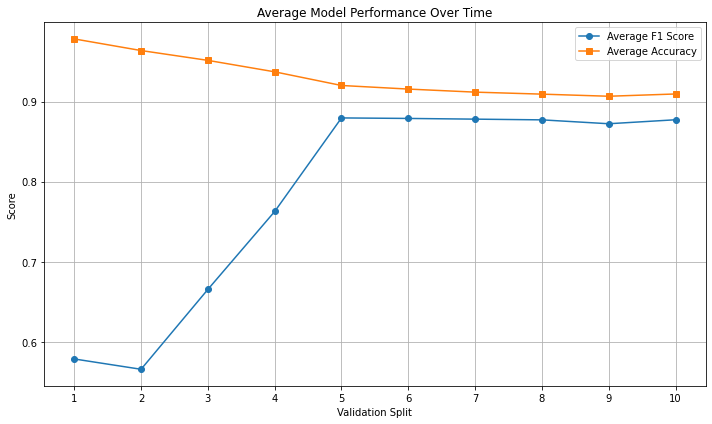

In [11]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

def load_data(file_path):
    """
    Load CSV file into a pandas DataFrame, remove columns with "time" in their names,
    and return the resulting DataFrame.
    """
    df = pd.read_csv(file_path)

    # Remove columns with "time" in their names
    time_cols = [col for col in df.columns if 'Time' in col]
    df = df.drop(columns=time_cols)

    # Group Stress_Score 1 and 2 as 1, leave 0 as 0
    df['Stress Levels'] = df['Stress Levels'].apply(lambda x: 1 if x in [1, 2] else 0)

    # Drop rows with NaN values
    df = df.dropna()

    return df

def train_test_model(df):
    """
    Train a random forest model on the given DataFrame to predict binary 'Stress_Score'.
    Use TimeSeriesSplit for temporal cross-validation.
    Return the combined f1-score, accuracy, and feature importance for each split.
    """
    f1_scores = []
    accuracy_scores = []
    feature_importances = []

    tscv = TimeSeriesSplit(n_splits=10)
    for train_index, test_index in tscv.split(df):
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]

        X_train, X_test = train_data.drop(columns=['Stress Levels']), test_data.drop(columns=['Stress Levels'])
        y_train, y_test = train_data['Stress Levels'], test_data['Stress Levels']

        # Perform stratified split on the training data
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.2,
            stratify=y_train,
        )

        # Train the model
        model = RandomForestClassifier()
        model.fit(X_train, y_train)

        # Evaluate the model on the validation set
        y_pred = model.predict(X_val)

        # Calculate combined f1-score and accuracy
        f1 = f1_score(y_val, y_pred, average='binary')
        accuracy = accuracy_score(y_val, y_pred)

        # Store feature importance
        feature_importances.append(model.feature_importances_)

        f1_scores.append(f1)
        accuracy_scores.append(accuracy)

    # Calculate average feature importance
    avg_feature_importance = np.mean(feature_importances, axis=0)

    return f1_scores, accuracy_scores, avg_feature_importance

source_directory = "/Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(source_directory, '*.csv'))

all_f1_scores = []
all_accuracy_scores = []
for file in csv_files:
    print("Processing file:", file)
    df = load_data(file)
    
    if df.empty:
        print("No data after removing 'time' columns.")
        continue

    f1_scores, accuracy_scores, _ = train_test_model(df)

    all_f1_scores.append(f1_scores)
    all_accuracy_scores.append(accuracy_scores)

# Average the F1 scores and accuracies
avg_f1_scores = np.mean(all_f1_scores, axis=0)
avg_accuracy_scores = np.mean(all_accuracy_scores, axis=0)

# Create the single plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_f1_scores) + 1), avg_f1_scores, label='Average F1 Score', marker='o')
plt.plot(range(1, len(avg_accuracy_scores) + 1), avg_accuracy_scores, label='Average Accuracy', marker='s')
plt.xlabel('Validation Split')
plt.ylabel('Score')
plt.title('Average Model Performance Over Time')
plt.xticks(range(1, len(avg_f1_scores) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("average_performance_plot.png")
plt.show()


## median model performance

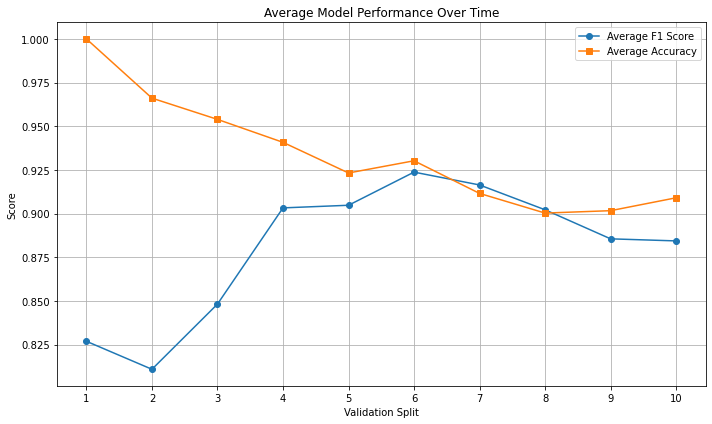

In [13]:
avg_f1_scores = np.median(all_f1_scores, axis=0)
avg_accuracy_scores = np.median(all_accuracy_scores, axis=0)

# Create the single plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_f1_scores) + 1), avg_f1_scores, label='Average F1 Score', marker='o')
plt.plot(range(1, len(avg_accuracy_scores) + 1), avg_accuracy_scores, label='Average Accuracy', marker='s')
plt.xlabel('Validation Split')
plt.ylabel('Score')
plt.title('Average Model Performance Over Time')
plt.xticks(range(1, len(avg_f1_scores) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("Median_performance_plot.png")
plt.show()

## experimenting with different graph styles

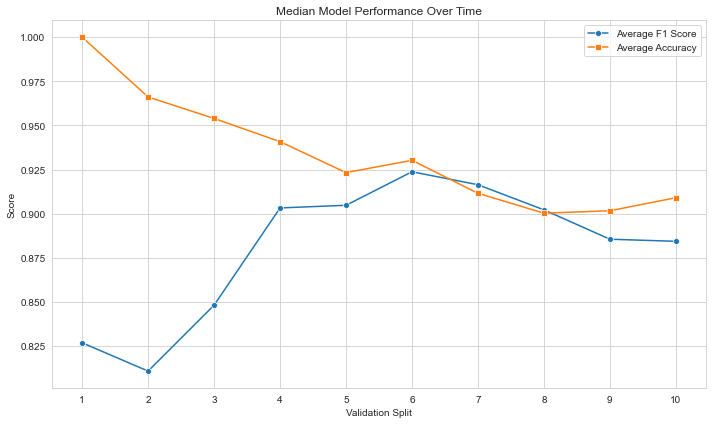

In [17]:
avg_f1_scores = np.median(all_f1_scores, axis=0)
avg_accuracy_scores = np.median(all_accuracy_scores, axis=0)

# Set Seaborn style
sns.set_style("whitegrid")

# Create the single plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(avg_f1_scores) + 1), y=avg_f1_scores, label='Average F1 Score', marker='o')
sns.lineplot(x=range(1, len(avg_accuracy_scores) + 1), y=avg_accuracy_scores, label='Average Accuracy', marker='s')
plt.xlabel('Validation Split')
plt.ylabel('Score')
plt.title('Median Model Performance Over Time')
plt.xticks(range(1, len(avg_f1_scores) + 1))
plt.legend()
plt.tight_layout()

plt.savefig("Median_performance_plot_seaborn.png")
plt.show()

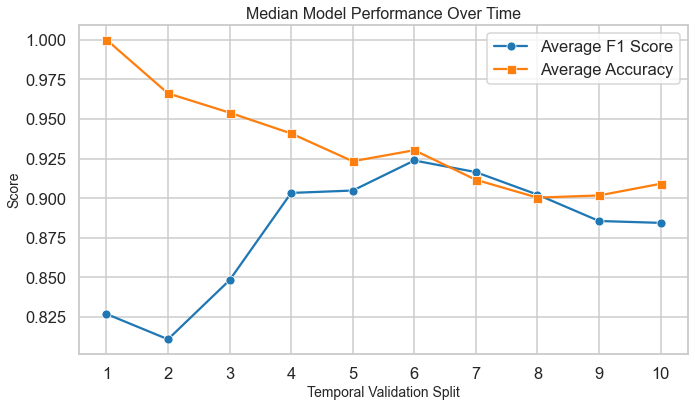

In [21]:
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the single plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(avg_f1_scores) + 1), y=avg_f1_scores, label='Average F1 Score', marker='o')
sns.lineplot(x=range(1, len(avg_accuracy_scores) + 1), y=avg_accuracy_scores, label='Average Accuracy', marker='s')
plt.xlabel('Temporal Validation Split', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Median Model Performance Over Time', fontsize=16)
plt.xticks(range(1, len(avg_f1_scores) + 1))
plt.legend()
plt.tight_layout()

plt.savefig("Median_performance_plot_seaborn.png")
plt.show()

## Stress Level Distribution Imbalance

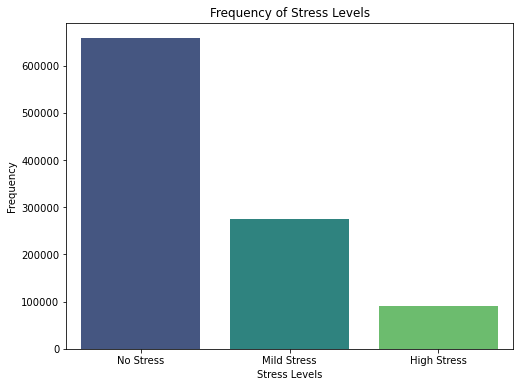

In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

source_directory = "/Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(source_directory, '*.csv'))

# Create an empty DataFrame to store combined data
combined_df = pd.DataFrame()

# Load all CSV files and combine into a single DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Count the occurrences of each stress level
stress_counts = combined_df['Stress Levels'].value_counts()

# Plot the frequencies with the viridis color scheme
plt.figure(figsize=(8, 6))
sns.barplot(x=stress_counts.index, y=stress_counts.values, palette='viridis')

# Set x-axis ticks and labels
plt.xticks(ticks=[0, 1, 2], labels=["No Stress", "Mild Stress", "High Stress"])

plt.title('Frequency of Stress Levels')
plt.xlabel('Stress Levels')
plt.ylabel('Frequency')
plt.show()


## proportion of explained variance, each prinicipal component

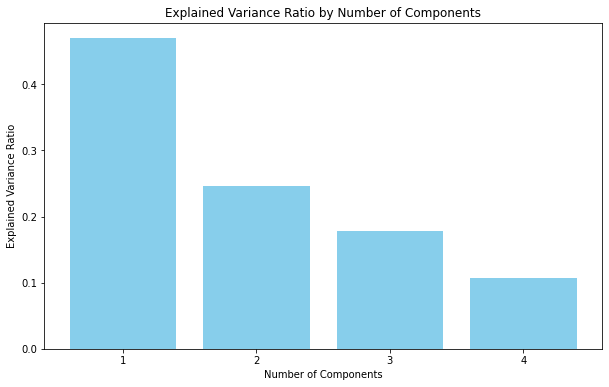


Top features contributing to Component 1:
1. Breathing Volume (liters/min)
2. Activity (g)
3. Heart Rate (bpm)
4. Respiration Rate (rpm)

Top features contributing to Component 2:
1. Respiration Rate (rpm)
2. Breathing Volume (liters/min)
3. Activity (g)
4. Heart Rate (bpm)

Top features contributing to Component 3:
1. Activity (g)
2. Breathing Volume (liters/min)
3. Respiration Rate (rpm)
4. Heart Rate (bpm)


In [5]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

source_directory = "/Users//Desktop/Final Files 04-06-24/final-hexo-04-06-24/modified files"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(source_directory, '*.csv'))

# Create a dictionary to store dataframes
dataframes = {}

# Load all CSV files into the dictionary
for file in csv_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    dataframes[file_name] = pd.read_csv(file)

# Concatenate all DataFrames into one
big_dataframe = pd.concat(dataframes.values(), ignore_index=True)

# Drop the column with 'Time'
big_dataframe = big_dataframe.drop(columns=[col for col in big_dataframe.columns if 'Time' in col])
big_dataframe = big_dataframe.drop(columns=[col for col in big_dataframe.columns if 'Stress' in col])
big_dataframe = big_dataframe.drop(columns=[col for col in big_dataframe.columns if 'Adjusted' in col])

# Perform Standard Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(big_dataframe)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='skyblue')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

# Show the features contributing to each component
n_components_to_show = 3  # You can adjust this value as needed
for i in range(n_components_to_show):
    component_num = i + 1
    component_features = pca.components_[i]
    sorted_indices = component_features.argsort()[::-1]
    top_features_indices = sorted_indices[:5]  # Show top 5 features
    top_features = big_dataframe.columns[top_features_indices]
    print(f"\nTop features contributing to Component {component_num}:")
    for j, feature in enumerate(top_features, start=1):
        print(f"{j}. {feature}")
